In [ ]:
# install python 3.9.12 

In [ ]:
# check for sanity

In [ ]:
# check for gpu and drivers
!nvidia-smi

In [2]:
!pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install tensorflow-privacy -q

In [4]:
# For GPU users
!pip install tensorflow[and-cuda]
# For CPU users
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
!python3 -c "import tensorflow as tf; print(tf.reduce_sum(tf.random.normal([1000, 1000])))"

In [ ]:
!python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

In [ ]:
# configure physical devices
import tensorflow  as tf
physical_devices = tf.config.list_physical_devices("GPU")
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [ ]:
#apply GPU startegy

strategy = tf.distribute.MirroredStrategy()
print('number of devices: {}'.format(strategy.num_replicas_in_sync))

In [9]:
import pip
pip.main(['install','pandas'])
import pandas

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Defaulting to user installation because normal site-packages is not writeable

Requirement already satisfied: pandas in /home/danielmachoka/.local/lib/python3.10/site-packages (1.5.3)

Requirement already satisfied: python-dateutil>=2.8.1 in /usr/lib/python3/dist-packages (from pandas) (2.8.1)

Requirement already satisfied: pytz>=2020.1 in /usr/lib/python3/dist-packages (from pandas) (2022.1)

Requirement already satisfied: numpy>=1.21.0 in /home/danielmachoka/.local/lib/python3.10/site-packages (from pandas) (1.26.4)

In [10]:
import pip
pip.main(['install','seaborn'])

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Defaulting to user installation because normal site-packages is not writeable

Requirement already satisfied: seaborn in /home/danielmachoka/.local/lib/python3.10/site-packages (0.13.2)

Requirement already satisfied: numpy!=1.24.0,>=1.20 in /home/danielmachoka/.local/lib/python3.10/site-packages (from seaborn) (1.26.4)

Requirement already satisfied: pandas>=1.2 in /home/danielmachoka/.local/lib/python3.10/site-packages (from seaborn) (1.5.3)

Requirement already satisfied: matplotlib!=3.6.1,>=3.4 in /usr/lib/python3/dist-packages (from seaborn) (3.5.1)

Requirement already satisfied: python-dateutil>=2.8.1 in /usr/lib/python3/dist-packages (from pandas>=1.2->seaborn) (2.8.1)

Requirement already satisfied: pytz>=2020.1 in /usr/lib/python3/dist-packages (from pandas>=1.2->seaborn) (2022.1)

0

In [11]:
# environmental reproducibility setup

# load necessary libraries first

import os
import time
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import resample, shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc
from sklearn.metrics import (
    recall_score,
    f1_score,
    precision_score,
    accuracy_score,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
     auc,
)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import TruePositives, TrueNegatives, FalsePositives, FalseNegatives

import tensorflow_privacy

from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from sklearn.model_selection import StratifiedKFold



#Filtering errors
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [12]:
#from google.colab import drive
#drive.mount('/content/drive')

## Load and Preprocess Data

In [13]:
data  = pd.read_csv('/home/danielmachoka/Downloads/RT_IOT2022.csv',low_memory=False, index_col = 0)

In [14]:
# Multiclass problem
display(data['Attack_type'].unique())
num_classes = data['Attack_type'].nunique()

array(['MQTT_Publish', 'Thing_Speak', 'Wipro_bulb', 'ARP_poisioning',
       'DDOS_Slowloris', 'DOS_SYN_Hping', 'Metasploit_Brute_Force_SSH',
       'NMAP_FIN_SCAN', 'NMAP_OS_DETECTION', 'NMAP_TCP_scan',
       'NMAP_UDP_SCAN', 'NMAP_XMAS_TREE_SCAN'], dtype=object)

In [15]:
# Label encode the target column
from sklearn.preprocessing import LabelEncoder

# Instantiate LabelEncoder
label_encoder = LabelEncoder()

# Encode the target column
data['Attack_type'] = label_encoder.fit_transform(data['Attack_type'])

In [16]:
# Identify non-numeric columns (only two so dropping)
print(data.select_dtypes(include='object').columns)

data.drop(['proto', 'service'], axis=1, inplace=True)

Index(['proto', 'service'], dtype='object')


In [17]:
target_column = 'Attack_type'
categorical_columns = [col for col in data.columns if col not in [target_column]] # Other columns

X = data.drop(target_column, axis=1)
y = data[target_column]

# Split into training test and validation datasets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



# Standard Scaling
scaler = StandardScaler()

#Perfom feature scaling for the training set
X_train_scaled = X_train.copy()
X_train_scaled[categorical_columns] = scaler.fit_transform(X_train[categorical_columns])

#Perfom feature scaling for the training set
X_valid_scaled = X_valid.copy()
X_valid_scaled[categorical_columns] = scaler.transform(X_valid[categorical_columns])

#Perfom feature scaling for the test set
X_test_scaled = X_test.copy()
X_test_scaled[categorical_columns] = scaler.transform(X_test[categorical_columns])

## Default MLP Model

In [18]:
with strategy.scope():
    mlp_model = Sequential()

# Add the first dense layer with dropout
    mlp_model.add(Dense(32, activation='relu', input_shape=(len(categorical_columns),)))
    mlp_model.add(Dropout(0.5))

# Add the second dense layer with dropout
    mlp_model.add(Dense(32, activation='relu'))
    mlp_model.add(Dropout(0.5))

# Add the output layer
    mlp_model.add(Dense(num_classes, activation='softmax'))

# Increase the learning rate for SGD optimizer
    learning_rate = 0.001,0.00001
    sgd_optimizer = SGD(learning_rate=learning_rate)
mlp_model.compile(optimizer=sgd_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Add early stopping
#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# Perform 5-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Set random_state for reproducibility
cv_results = []

for train_index, test_index in kfold.split(X_train_scaled[categorical_columns], y_train):
    X_train_fold, X_val_fold = X_train_scaled[categorical_columns].iloc[train_index], X_train_scaled[categorical_columns].iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Train the model on the current fold
    model_history = mlp_model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=128, validation_data=(X_val_fold, y_val_fold))

    # Evaluate on the validation set
    val_loss, val_accuracy = mlp_model.evaluate(X_val_fold, y_val_fold)
    cv_results.append((val_loss, val_accuracy))

# Predict on the test data
y_test_pred_mlp = mlp_model.predict(X_test_scaled[categorical_columns])

# Convert probability predictions to class labels
y_test_pred_classes_mlp = np.argmax(y_test_pred_mlp, axis=1)

Epoch 1/50
INFO:tensorflow:Collective all_reduce tensors: 6 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


Collective all_reduce tensors: 6 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).

INFO:tensorflow:Collective all_reduce tensors: 6 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


Collective all_reduce tensors: 6 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).

2024-02-21 01:28:35.368005: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fb06d368980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-21 01:28:35.368070: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2024-02-21 01:28:35.368083: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): Quadro RTX 5000, Compute Capability 7.5
2024-02-21 01:28:35.368093: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (2): Quadro RTX 5000, Compute Capability 7.5
2024-02-21 01:28:35.368102: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (3): Quadro RTX 5000, Compute Capability 7.5
2024-02-21 01:28:35.387487: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-21 01:28:35.391475: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN ver

538/539 [============================>.] - ETA: 0s - loss: 1.6968 - accuracy: 0.6393INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).

539/539 [==============================] - 10s 9ms/step - loss: 1.6958 - accuracy: 0.6395 - val_loss: 0.7061 - val_accuracy: 0.7798
Epoch 2/50
539/539 [==============================] - 4s 8ms/step - loss: 0.8059 - accuracy: 0.7958 - val_loss: 0.5038 - val_accuracy: 0.8065
Epoch 3/50
539/539 [==============================] - 4s 8ms/step - loss: 0.6552 - accuracy: 0.8099 - val_loss: 0.4321 - val_accuracy: 0.8283
Epoch 4/50
539/539 [==============================] - 4s 8ms/step - loss: 0.5850 - accuracy: 0.8195 - val_loss: 0.3840 - val_accuracy: 0.8474
Epoch 5/50
539/539 [==============================] - 4s 8ms/step - loss: 0.5338 - accuracy: 0.8297 - val_loss: 0.3473 - val_accuracy: 0.8817
Epoch 6/50
539/539 [==============================] - 4s 8ms/step - loss: 0.4898 - accuracy: 0.8419 - val_loss: 0.3176 - val_accuracy: 0.9098
Epoch 7/50
539/539 [==============================] - 4s 8ms/step - loss: 0.4574 - accuracy: 0.8496 - val_loss: 0.2921 - val_accuracy: 0.9132
Epoch 8/50
539/5

In [19]:
# Print the average cross-validation results
print("Average cross-validation loss:", sum(cv_result[0] for cv_result in cv_results) / len(cv_results))
print("Average cross-validation accuracy:", sum(cv_result[1] for cv_result in cv_results) / len(cv_results))

# Evaluate the MLP model
accuracy_mlp = accuracy_score(y_test, y_test_pred_classes_mlp)
precision_mlp = precision_score(y_test, y_test_pred_classes_mlp, average='macro')
recall_mlp = recall_score(y_test, y_test_pred_classes_mlp, average='macro')
f1_mlp = f1_score(y_test, y_test_pred_classes_mlp, average='macro')

# Print the results for the MLP model
print("MLP Model:")
print(f"Accuracy =  {accuracy_mlp}")
print(f"Precision = {precision_mlp}")
print(f"Recall = {recall_mlp}")
print(f"F1 Score =  {f1_mlp}")

Average cross-validation loss: 0.09666119813919068
Average cross-validation accuracy: 0.9648298978805542
MLP Model:
Accuracy =  0.9746588693957114
Precision = 0.7141265105939202
Recall = 0.6395939704744497
F1 Score =  0.640726421305169


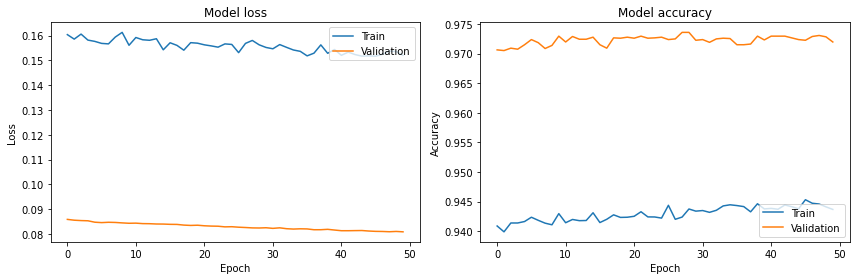

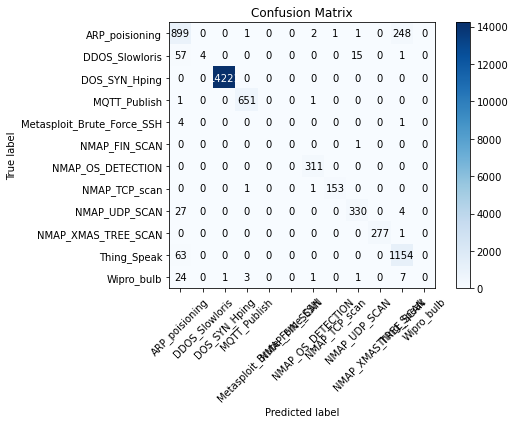

In [20]:
# Function to plot loss curves
def plot_loss(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.tight_layout()
    plt.show()

# Plot loss curves
plot_loss(model_history)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_classes_mlp)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

num_classes = conf_matrix.shape[0]

# Get class labels from the LabelEncoder
class_labels = label_encoder.classes_

plt.xticks(np.arange(num_classes), class_labels, rotation=45)
plt.yticks(np.arange(num_classes), class_labels)

thresh = conf_matrix.max() / 2.

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

# Precision-Recall Curve (Not possible for Multiclass Classification, it is designed for Binary Class only)
# precision, recall, thresholds = precision_recall_curve(y_test_binary_true, y_test_pred_mlp)
# area_under_curve = auc(recall, precision)

# plt.figure(figsize=(8, 6))
# plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {area_under_curve:.2f})')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.legend(loc='lower left')
# plt.show()

## Privacy

In [ ]:
# Define your MLP model
with strategy.scope():
    mlp_model_privacy = tf.keras.Sequential([
        tf.keras.layers.Dense(16, activation='relu', input_shape=(len(categorical_columns),)),
        tf.keras.layers.Dropout(0.85),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.85),
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Define differential privacy parameters
batch_size = 16
l2_norm_clip = 1.0
noise_multiplier = 1.3
num_microbatches = 1

# Create a DP optimizer
optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=0.001,0.00001
)

# y_train2 = tf.keras.utils.to_categorical(y_train, num_classes=2)
# y_valid2 = tf.keras.utils.to_categorical(y_valid, num_classes=2)

# Compile the model with the DP optimizer and loss function
mlp_model_privacy.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with differential privacy

# Perform 5-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

for train_index, test_index in kfold.split(X_train_scaled[categorical_columns], y_train):
    X_train_fold, X_val_fold = X_train_scaled[categorical_columns].iloc[train_index], X_train_scaled[categorical_columns].iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Reshape
    # y_train_fold2 = tf.keras.utils.to_categorical(y_train_fold, num_classes=2)
    # y_val_fold2 = tf.keras.utils.to_categorical(y_val_fold, num_classes=2)

    # Train the model with DP for this fold
    model_history_privacy = mlp_model_privacy.fit(X_train_fold, y_train_fold,
              epochs=50,
              validation_data=(X_val_fold, y_val_fold),
              batch_size=batch_size // num_microbatches)

    # Evaluate on the validation set
    val_loss, val_accuracy = mlp_model_privacy.evaluate(X_val_fold, y_val_fold)
    cv_results.append((val_loss, val_accuracy))


In [22]:
# Predict on the test data
y_test_pred_mlp_privacy = mlp_model_privacy.predict(X_test_scaled[categorical_columns])

# # Apply the threshold to make binary predictions
y_test_pred_binary_mlp_privacy = y_test_pred_mlp_privacy.argmax(axis=1)

578/578 [==============================] - 3s 3ms/step


In [23]:
# Print the average cross-validation results
print("Average cross-validation loss:", sum(cv_result[0] for cv_result in cv_results) / len(cv_results))
print("Average cross-validation accuracy:", sum(cv_result[1] for cv_result in cv_results) / len(cv_results))

# Evaluate the MLP model
accuracy_mlp_privacy = accuracy_score(y_test, y_test_pred_binary_mlp_privacy)
precision_mlp_privacy = precision_score(y_test, y_test_pred_binary_mlp_privacy, average='macro')
recall_mlp_privacy = recall_score(y_test, y_test_pred_binary_mlp_privacy, average='macro')
f1_mlp_privacy = f1_score(y_test, y_test_pred_binary_mlp_privacy, average='macro')

# Print the results for the MLP model
print("MLP Model:")
print(f"Accuracy =  {accuracy_mlp_privacy}")
print(f"Precision = {precision_mlp_privacy}")
print(f"Recall = {recall_mlp_privacy}")
print(f"F1 Score =  {f1_mlp_privacy}")

Average cross-validation loss: 690.0384399414063
Average cross-validation accuracy: 0.768730902671814
MLP Model:
Accuracy =  0.7700346545375785
Precision = 0.06416955454479821
Recall = 0.08333333333333333
F1 Score =  0.07250655164326429


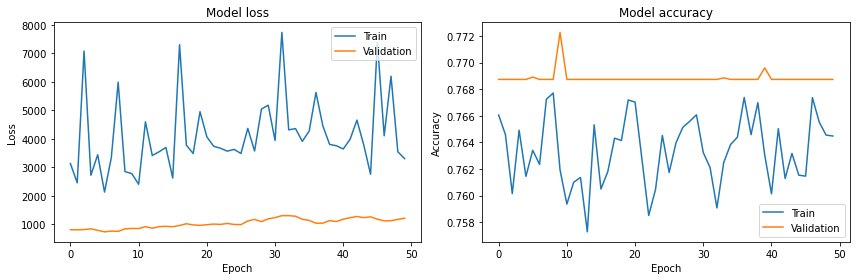

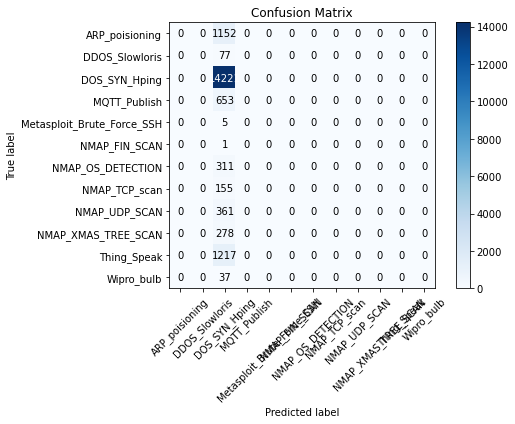

In [24]:
# Plot loss curves
plot_loss(model_history_privacy)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_binary_mlp_privacy)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

num_classes = conf_matrix.shape[0]

# Get class labels from the LabelEncoder
class_labels = label_encoder.classes_

plt.xticks(np.arange(num_classes), class_labels, rotation=45)
plt.yticks(np.arange(num_classes), class_labels)

thresh = conf_matrix.max() / 2.

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

# Precision-Recall Curve
# precision, recall, thresholds = precision_recall_curve(y_test_binary_true, y_test_pred_binary_mlp_privacy)
# area_under_curve = auc(recall, precision)

# plt.figure(figsize=(8, 6))
# plt.plot(recall, precision, label=f'Privacy Model Precision-Recall Curve (AUC = {area_under_curve:.2f})')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Privacy Model Precision-Recall Curve')
# plt.legend(loc='lower left')
# plt.show()

In [25]:
# Extract trainable variables from the model
trainable_variables = mlp_model_privacy.trainable_variables

# Compute privacy budget
privacy_report = compute_dp_sgd_privacy.compute_dp_sgd_privacy_statement(
    number_of_examples=len(X_train_scaled),
    batch_size=batch_size,
    noise_multiplier=noise_multiplier,
    num_epochs=50,
    delta=1e-5
)

In [26]:
print(privacy_report)

DP-SGD performed over 86181 examples with 16 examples per iteration, noise
multiplier 1.3 for 50 epochs with microbatching, and no bound on number of
examples per user.

This privacy guarantee protects the release of all model checkpoints in addition
to the final model.

Example-level DP with add-or-remove-one adjacency at delta = 1e-05 computed with
RDP accounting:
    Epsilon with each example occurring once per epoch:       109.529
    Epsilon assuming Poisson sampling (*):                      1.959

No user-level privacy guarantee is possible without a bound on the number of
examples per user.

(*) Poisson sampling is not usually done in training pipelines, but assuming
that the data was randomly shuffled, it is believed the actual epsilon should be
closer to this value than the conservative assumption of an arbitrary data
order.

